<a href="https://colab.research.google.com/github/GitGreg228/sepmp_ml_2023/blob/main/lecture_codes/lecture_7_supporting_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from copy import deepcopy
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from tqdm import tqdm
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.decomposition import PCA

# Intro to Pytorch - differentiation

$$
y(\mathbf{x}) = 1 - \sum_i^n x^2_i
$$
where 
* $\mathbf{x} \in \mathbb{R}^n = (x_1, x_2, ..., x_n)$
* $y: \mathbb{R}^n \rightarrow \mathbb{R}$

In [2]:
x = np.array([0., 1., 2., 3.])
y = 1 - np.sum(np.square(x))
print(x, y)

[0. 1. 2. 3.] -13.0


\begin{align}
\mathrm{grad} y = \nabla_{\mathbf{x}} y &= (\frac{\partial y}{\partial x_1}, \frac{\partial y}{\partial x_2}, ..., \frac{\partial y}{\partial x_n}) \\
\frac{\partial y}{\partial x_i} &= -2 x_i
\end{align}

In [3]:
x = torch.tensor([0., 1., 2., 3.], requires_grad=True)
y = 1 - torch.sum(torch.square(x))

y.backward()
print(f'x = {x}')
print(f'(pytorch) grad y = {x.grad}')
print(f'(analytical) grad y = {-2 * x}')

x = tensor([0., 1., 2., 3.], requires_grad=True)
(pytorch) grad y = tensor([-0., -2., -4., -6.])
(analytical) grad y = tensor([-0., -2., -4., -6.], grad_fn=<MulBackward0>)


back to numpy:

In [4]:
x.detach().numpy()

array([0., 1., 2., 3.], dtype=float32)

# Modules

Linear: 
$$
f(\mathbf{x}, \mathbf{w}, b) = \mathbf{w}\mathbf{x}^{\mathrm{T}} + b = w_1x_1 + w_2x_2 + ... + w_nx_n + b
$$
where
* $\mathbf{x} = (x_1, x_2, ..., x_n) \in \mathbb{R}^n$
* $\mathbf{w} = (w_1, w_2, ..., w_n) \in \mathbb{R}^n$
* $b \in \mathbb{R}$
* $f: \mathbb{R}^n \rightarrow \mathbb{R}$

In [5]:
f = torch.nn.Linear(4, 1)
print(f.weight, f.bias)

Parameter containing:
tensor([[ 0.3337,  0.0847,  0.0996, -0.4545]], requires_grad=True) Parameter containing:
tensor([0.4087], requires_grad=True)


In [6]:
print(f'x = {x}')
print(f'torch: {f(x)}')
print(f'analytical: {torch.sum(f.weight * x) + f.bias}')

x = tensor([0., 1., 2., 3.], requires_grad=True)
torch: tensor([-0.6709], grad_fn=<AddBackward0>)
analytical: tensor([-0.6709], grad_fn=<AddBackward0>)


Linear can be more complex:

$$
f(\mathbf{x}, \mathbf{W}, \mathbf{b}) = \mathbf{W}\mathbf{x}^{\mathrm{T}} + \mathbf{b} = \begin{pmatrix} w_{11}x_1 + w_{12}x_2 + ... + w_{1n}x_n + b_1 \\ 
w_{21}x_1 + w_{22}x_2 + ... + w_{2n}x_n + b_2
\end{pmatrix}
$$

where
* $\mathbf{x} = (x_1, x_2, ..., x_n) \in \mathbb{R}^n$
* $\mathbf{W} = \begin{pmatrix} w_{11}, w_{12}, ..., w_{1n} \\  w_{21}, w_{22}, ..., w_{2n}  \end{pmatrix} \in \mathbb{R}^{2n}$
* $\mathbf{b} = \begin{pmatrix} b_1\\b_2 \end{pmatrix} \in \mathbb{R}^2$
* $f: \mathbb{R}^n \rightarrow \mathbb{R}^2$

In [7]:
f = torch.nn.Linear(4, 2)
print(f.weight, f.bias)

Parameter containing:
tensor([[-0.4449,  0.0080, -0.2145,  0.4472],
        [ 0.3255, -0.0139,  0.3747,  0.0175]], requires_grad=True) Parameter containing:
tensor([ 0.4500, -0.3907], requires_grad=True)


In [8]:
print(f'x = {x}')
print(f'torch: {f(x)}')
print(f'analytical: {torch.matmul(f.weight, x) + f.bias}')

x = tensor([0., 1., 2., 3.], requires_grad=True)
torch: tensor([1.3706, 0.3973], grad_fn=<AddBackward0>)
analytical: tensor([1.3706, 0.3973], grad_fn=<AddBackward0>)


# Sigmoid

$$
\sigma(\mathbf{x}) = \frac{1}{1+e^{-\mathbf{x}}}
$$

$\sigma(\mathbf{x}) : \mathbb{R}^n \rightarrow (0, 1)^n$

In [9]:
print(f'x = {x}')
print(f'torch: {x.sigmoid()}')
print(f'analytical: {1 / (1 + torch.exp(-x))}')

x = tensor([0., 1., 2., 3.], requires_grad=True)
torch: tensor([0.5000, 0.7311, 0.8808, 0.9526], grad_fn=<SigmoidBackward0>)
analytical: tensor([0.5000, 0.7311, 0.8808, 0.9526], grad_fn=<MulBackward0>)


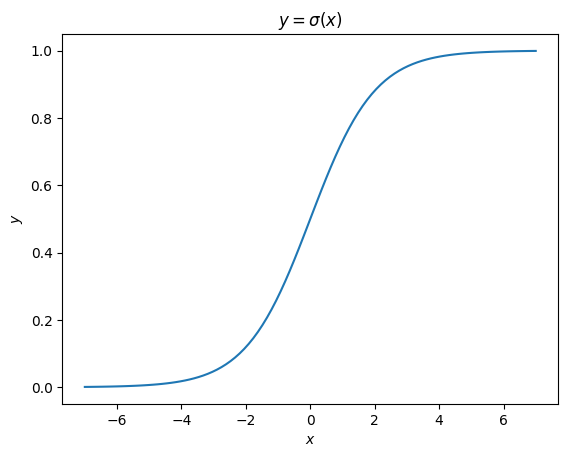

In [10]:
x = torch.linspace(-7, 7, 100, requires_grad=True)
plt.plot(x.detach(), x.sigmoid().detach())
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'$y = \sigma(x)$')
plt.show()

# Combining modules

In [11]:
f = torch.nn.Sequential(
    torch.nn.Linear(4, 1),
    torch.nn.Sigmoid(),
)
list(f.parameters())

[Parameter containing:
 tensor([[-0.2758, -0.0224, -0.4976, -0.1925]], requires_grad=True),
 Parameter containing:
 tensor([0.0890], requires_grad=True)]

# Let's do Logistic regression on IRIS

In [12]:
X, y = load_iris(return_X_y=True)
mask = y != 0
X = X[mask]
y = y[mask]

y[y == 1] = 0
y[y == 2] = 1

X = torch.FloatTensor(X)
y = torch.FloatTensor(y)
print(X.shape, y.shape)

torch.Size([100, 4]) torch.Size([100])


## LogReg Loss:

$$
L_{\mathrm{LogReg}}(\mathbf{M}) = \frac{1}{n_{\mathrm{objects}}} \sum_i^{n_{\mathrm{objects}}} \log(1 + \exp\left(-M_i\right)) 
$$

where:
* $L_{\mathrm{LogReg}} : \mathbb{R}^{n_{\mathrm{objects}}} → \mathbb{R}^+$
* $\mathbf{M} = \begin{pmatrix} M_1 \\ M_2 \\ ... \\ M_{n_{\mathrm{objects}}} \end{pmatrix} = \begin{pmatrix} y_1 (\mathbf{w}\mathbf{x}_1^{\mathrm{T}} + b) \\ y_2 (\mathbf{w}\mathbf{x}_2^{\mathrm{T}} + b) \\ ... \\ y_{n_{\mathrm{objects}}} (\mathbf{w}\mathbf{x}_{n_{\mathrm{objects}}}^{\mathrm{T}} + b) \end{pmatrix} \in \mathbb{R}^{n_{\mathrm{objects}}} $

In [13]:
f = torch.nn.Linear(4, 1)

def loss_function(X, f, y):
    margin = y * f(X).T
    return torch.mean(torch.log(1 + torch.exp(-margin)))

loss = loss_function(X, f, y)
loss.backward()
print(f.weight.grad, f.bias.grad)

tensor([[-2.9723, -1.3419, -2.5037, -0.9144]]) tensor([-0.4505])


## Gradient descent (optimization)

for i in 1 ... n_steps:
1. Predict $\hat y = f(X)$
2. Calculate loss function $L(y, \hat y)$
3. Calculate loss gradients $\frac{\partial L}{\partial w_i}$ and $\frac{\partial L}{\partial b}$
4. Update weights: $w_i \rightarrow w_i - \alpha \frac{\partial L}{\partial w_i}$, $b \rightarrow b - \alpha \frac{\partial L}{\partial b}$

Learn more:
* [torch.optim.SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)
* [torch.optim.Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)

In [14]:
# lr (learning rate) is alpha; SGD - stochastic gradient descent
f = torch.nn.Linear(4, 1)

alpha = 0.001
optimizer = torch.optim.SGD(f.parameters(), lr=alpha)

# set gradients to zero to calculate new ones 
optimizer.zero_grad()

# updating the gradients
optimizer.step()

for i in range(20):
    loss = loss_function(X, f, y)
    print(loss.item())
    # optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0.35733211040496826
0.35732269287109375
0.35730376839637756
0.3572756052017212
0.3572380840778351
0.3571915030479431
0.35713595151901245
0.3570716083049774
0.3569987118244171
0.35691753029823303
0.3568283021450043
0.3567312955856323
0.3566268980503082
0.3565153479576111
0.3563970923423767
0.35627245903015137
0.3561417758464813
0.3560054898262024
0.3558639585971832
0.35571762919425964


# Neural network notation
* [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)

In [15]:
class Logistic_Regression(torch.nn.Module):
    def __init__(self, in_size=4, out_size=1):
        super().__init__()
        self.layers = torch.nn.Sequential(
                torch.nn.Linear(in_size, out_size),
                torch.nn.Sigmoid(),
            )
    
    def forward(self, x):
        return self.layers(x)

In [16]:
model = Logistic_Regression()
list(model.parameters())

[Parameter containing:
 tensor([[-0.3439, -0.4053,  0.0284,  0.3957]], requires_grad=True),
 Parameter containing:
 tensor([-0.2461], requires_grad=True)]

## Data Loaders
* [torch.utils.data](https://pytorch.org/docs/stable/data.html)

In [17]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

torch.Size([80, 4]) torch.Size([10, 4]) torch.Size([10, 4])


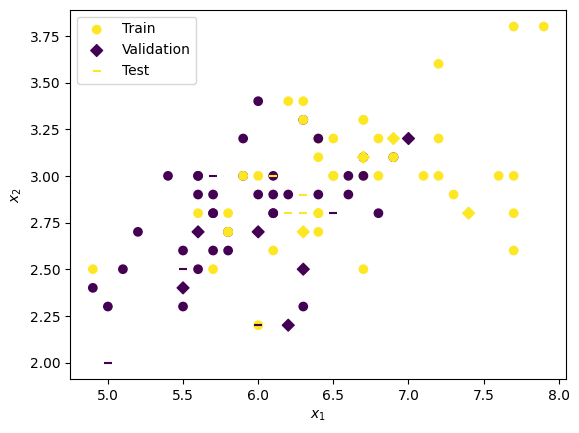

In [18]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, label='Train')
plt.scatter(X_val[:, 0], X_val[:, 1], marker='D', c=y_val, label='Validation')
plt.scatter(X_test[:, 0], X_test[:, 1], marker='_', c=y_test, label='Test')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.legend()
plt.show()

In [19]:
bs = 10  # batch_size

train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=bs)
val_loader = DataLoader(val_data, batch_size=bs)
test_loader = DataLoader(test_data, batch_size=bs)

In [20]:
# usage
for batch in test_loader:
    _X, _y = batch
    print(_X)
    print(_y.unsqueeze(1))

tensor([[6.3000, 2.8000, 5.1000, 1.5000],
        [6.1000, 3.0000, 4.9000, 1.8000],
        [6.5000, 2.8000, 4.6000, 1.5000],
        [6.3000, 2.9000, 5.6000, 1.8000],
        [5.0000, 2.0000, 3.5000, 1.0000],
        [5.5000, 2.5000, 4.0000, 1.3000],
        [5.5000, 2.4000, 3.8000, 1.1000],
        [5.7000, 3.0000, 4.2000, 1.2000],
        [6.0000, 2.2000, 4.0000, 1.0000],
        [6.2000, 2.8000, 4.8000, 1.8000]])
tensor([[1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.]])


## Binary Cross Entropy (BCE) Loss

$$
L_{\mathrm{BCE}} (\mathbf{y}, \hat{\mathbf{y}}) = - \frac{1}{n_{\mathrm{objects}}} \sum_i^{n_{\mathrm{objects}}} \left[y_i \log(\hat y_i) + (1-y_i) \log(1-\hat y_i) \right]
$$

where
* $\mathbf{y} \in \{0, 1\}^{n_{\mathrm{objects}}}$
* $\hat{\mathbf{y}} \in (0, 1)^{n_{\mathrm{objects}}}$

Learn more:
* [torch.nn.BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)

In [21]:
def train(model, criterion, optimizer, n_epochs, n_stop=10):
    train_loss = list()
    val_loss = list()
    min_val_loss = np.inf
    f = 0
    for epoch in tqdm(range(n_epochs)):
        model.train()
        train_batch_loss = list()
        for batch in train_loader:
            optimizer.zero_grad()
            _X, _y = batch
            _y_pred = model(_X)
            loss = criterion(_y_pred, _y.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_batch_loss.append(loss.item())

        model.eval()
        val_batch_loss = list()
        for batch in val_loader:
            _X, _y = batch
            _y_pred = model(_X)
            loss = criterion(_y_pred, _y.unsqueeze(1))
            val_batch_loss.append(loss.item())

        # print(f'Epoch: {epoch}, \tTrain loss: {np.mean(train_batch_loss)}, \tValidation loss: {np.mean(val_batch_loss)}')
        train_loss.append(np.mean(train_batch_loss))
        val_loss.append(np.mean(val_batch_loss))

        # (optional) early stopping:

        if val_loss[-1] > min_val_loss:
            f = f + 1
        else:
            # print(f'epoch: {epoch}, val loss did decrease, saving model')
            f = 0
            best_model = deepcopy(model)
            min_val_loss = val_loss[-1]
        if f >= n_stop:
            print(f'epoch: {epoch}, val loss did not decrease for {f} epoch(s)')
            break

    return best_model, train_loss, val_loss

In [35]:
model = Logistic_Regression()

criterion = torch.nn.BCELoss()

alpha = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=alpha)

model, train_loss, val_loss = train(model, criterion, optimizer, n_epochs=10000, n_stop=1000)

 36%|███▌      | 3605/10000 [00:27<00:48, 133.10it/s]

epoch: 3605, val loss did not decrease for 1000 epoch(s)


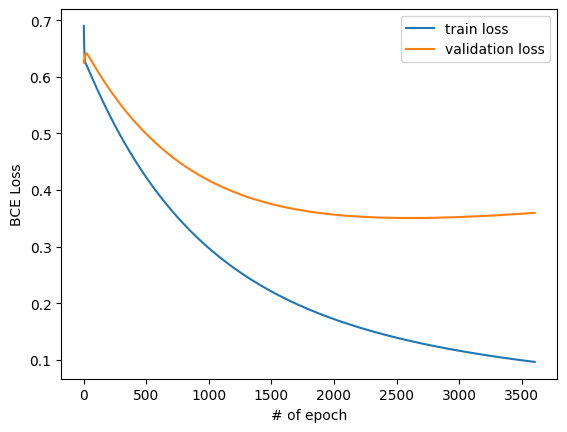

In [36]:
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='validation loss')
plt.legend()
plt.ylabel('BCE Loss')
plt.xlabel('# of epoch')
plt.show()

In [37]:
with torch.no_grad():
    for batch in test_loader:
        _X, _y = batch
        _y_pred = model(_X)
        loss = criterion(_y_pred, _y.unsqueeze(1))
        print(f'y: {_y.unsqueeze(1)}, \ny_pred = {_y_pred}, \nloss = {loss.item()}')

y: tensor([[1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.]]), 
y_pred = tensor([[0.4794],
        [0.6591],
        [0.2035],
        [0.8924],
        [0.0879],
        [0.1597],
        [0.0590],
        [0.0432],
        [0.0500],
        [0.6887]]), 
loss = 0.22889406979084015


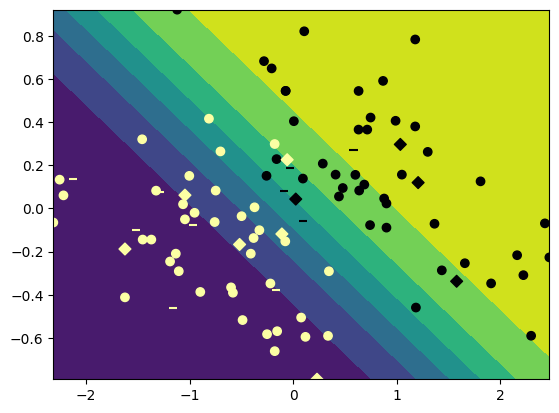

In [25]:
pca = PCA(n_components=2)
X_new = pca.fit_transform(X)
feature_1, feature_2 = np.meshgrid(
    np.linspace(X_new[:, 0].min(), X_new[:, 0].max()),
    np.linspace(X_new[:, 1].min(), X_new[:, 1].max()),
)
grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T
y_pred = model(torch.Tensor(pca.inverse_transform(grid)))
y_pred = np.reshape(y_pred.detach().numpy(), feature_1.shape)
display = DecisionBoundaryDisplay(
    xx0=feature_1, xx1=feature_2, response=y_pred
)
display.plot()
X_new_train = pca.transform(X_train)
X_new_val = pca.transform(X_val)
X_new_test = pca.transform(X_test)
display.ax_.scatter(X_new_train[:, 0], X_new_train[:, 1], c=y_train, cmap='inferno_r')
display.ax_.scatter(X_new_val[:, 0], X_new_val[:, 1], c=y_val, marker='D', cmap='inferno_r')
display.ax_.scatter(X_new_test[:, 0], X_new_test[:, 1], c=y_test, marker='_', cmap='inferno_r')

# Investigation of Neural Network architecture

Learn more:
* [torchviz](https://github.com/szagoruyko/pytorchviz)
* [torchsummary](https://github.com/sksq96/pytorch-summary)

In [26]:
%pip install -q -U git+https://github.com/szagoruyko/pytorchviz.git@master
from torchviz import make_dot
from torchsummary import summary

  Preparing metadata (setup.py) ... done


In [27]:
print(X_train.shape)

torch.Size([80, 4])


In [28]:
summary(model, input_size=X_train.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 80, 1]               5
           Sigmoid-2                [-1, 80, 1]               0
Total params: 5
Trainable params: 5
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


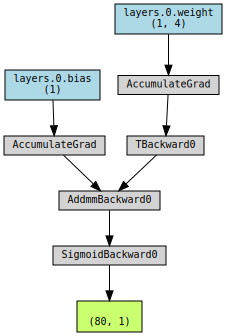

In [29]:
make_dot(model(X_train), params=dict(model.named_parameters()))

# Stack more layers

In [30]:
class Logistic_Regression_Five_Layers(torch.nn.Module):
    def __init__(self, in_size=4, out_size=1):
        super().__init__()
        self.layers = torch.nn.Sequential(
                torch.nn.Linear(in_size, 8),
                torch.nn.Sigmoid(),
                torch.nn.Linear(8, 16),
                torch.nn.Sigmoid(),
                torch.nn.Linear(16, 8),
                torch.nn.Sigmoid(),
                torch.nn.Linear(8, 4),
                torch.nn.Sigmoid(),
                torch.nn.Linear(4, out_size),
                torch.nn.Sigmoid()
            )
    
    def forward(self, x):
        return self.layers(x)

In [31]:
model = Logistic_Regression_Five_Layers()
summary(model, input_size=X_train.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 80, 8]              40
           Sigmoid-2                [-1, 80, 8]               0
            Linear-3               [-1, 80, 16]             144
           Sigmoid-4               [-1, 80, 16]               0
            Linear-5                [-1, 80, 8]             136
           Sigmoid-6                [-1, 80, 8]               0
            Linear-7                [-1, 80, 4]              36
           Sigmoid-8                [-1, 80, 4]               0
            Linear-9                [-1, 80, 1]               5
          Sigmoid-10                [-1, 80, 1]               0
Total params: 361
Trainable params: 361
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.00
Estimated Total Siz

In [32]:
model = Logistic_Regression_Five_Layers()

criterion = torch.nn.BCELoss()

alpha = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=alpha)

model, train_loss, val_loss = train(model, criterion, optimizer, n_epochs=10000, n_stop=1000)

 14%|█▍        | 1388/10000 [00:35<03:38, 39.46it/s]

epoch: 1388, val loss did not decrease for 1000 epoch(s)


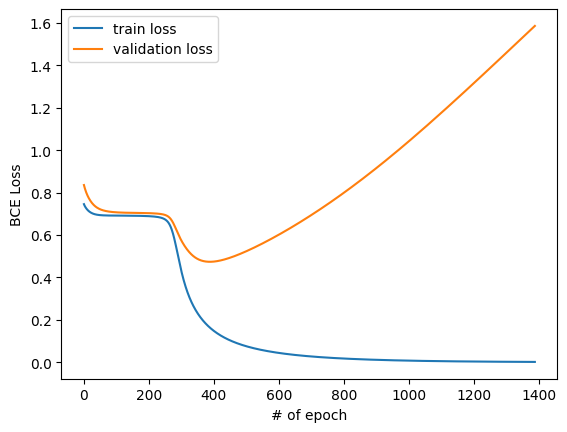

In [33]:
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='validation loss')
plt.legend()
plt.ylabel('BCE Loss')
plt.xlabel('# of epoch')
plt.show()

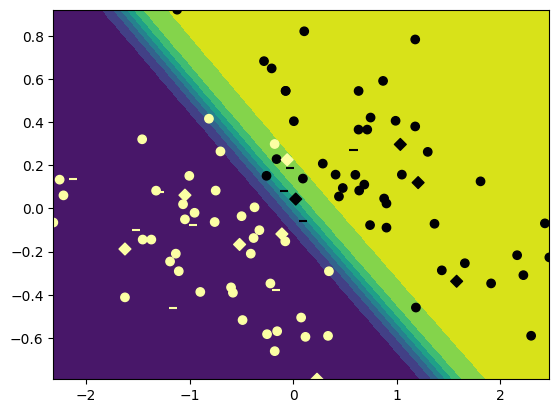

In [34]:
pca = PCA(n_components=2)
X_new = pca.fit_transform(X)
feature_1, feature_2 = np.meshgrid(
    np.linspace(X_new[:, 0].min(), X_new[:, 0].max()),
    np.linspace(X_new[:, 1].min(), X_new[:, 1].max()),
)
grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T
y_pred = model(torch.Tensor(pca.inverse_transform(grid)))
y_pred = np.reshape(y_pred.detach().numpy(), feature_1.shape)
display = DecisionBoundaryDisplay(
    xx0=feature_1, xx1=feature_2, response=y_pred
)
display.plot()
X_new_train = pca.transform(X_train)
X_new_val = pca.transform(X_val)
X_new_test = pca.transform(X_test)
display.ax_.scatter(X_new_train[:, 0], X_new_train[:, 1], c=y_train, cmap='inferno_r')
display.ax_.scatter(X_new_val[:, 0], X_new_val[:, 1], c=y_val, marker='D', cmap='inferno_r')
display.ax_.scatter(X_new_test[:, 0], X_new_test[:, 1], c=y_test, marker='_', cmap='inferno_r')